Copyright © 2023, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Exams Dataset : Assess Bias of Regression Models

This notebook provides an example of how to assess bias in python models using the exam dataset [^1].  The `assess_model_bias()` function featured in this notebook produces JSON files that can be uploaded into Model Manager on SAS Viya 4. Lines of code that must be modified by the user, such as directory paths or the host server are noted with the comment "_Changes required by user._"

_**Note:** If you download only this notebook and not the rest of the repository, you must also download the exams.csv file from the data folder in the examples directory. These files are used when executing this notebook example._

Here are the steps shown in this notebook:

1. [Import Modules](#section_0)
2. [Import, review, and preprocess data for model training.](#section_1)
3. [Build, train, and assess a scikit-learn models.](#section_2)
4. [Create score tables for models.](#section_3)
5. [Call `assess_model_bias()` to create JSON files and return relevant data frames.](#section_4)
6. [Review data frames from assess bias function and generate graphics similar to Model Studio.](#section_5)

[^1]: source: http://roycekimmons.com/tools/generated_data/exams

<a id='section_0'></a>

## Import Modules

In [7]:
from sasctl import Session
import sasctl.pzmm as pzmm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import numpy as np
from pathlib import Path
import getpass
import matplotlib.pyplot as plt

<a id='section_1'></a>

## Load, Assess, and Pre-process Data

In [8]:
df_raw = pd.read_csv("data/exams.csv")
df_raw.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,none,62,59,53
1,female,group E,some high school,free/reduced,completed,56,62,64
2,female,group E,some college,standard,completed,91,97,96
3,female,group D,some college,standard,completed,81,93,99
4,male,group E,associate's degree,free/reduced,none,73,62,57


math score                                                  \
                    count       mean        std   min    25%   50%    75%   
race/ethnicity                                                              
group A              62.0  67.387097  14.602217  33.0  57.25  69.0  78.75   
group B             199.0  63.738693  16.392042  24.0  53.00  64.0  76.00   
group C             342.0  64.909357  14.419377  19.0  56.00  66.0  74.00   
group D             245.0  67.987755  14.207329  24.0  58.00  67.0  78.00   
group E             152.0  76.578947  14.315983  40.0  67.00  77.0  87.25   

                       
                  max  
race/ethnicity         
group A         100.0  
group B          96.0  
group C         100.0  
group D         100.0  
group E         100.0

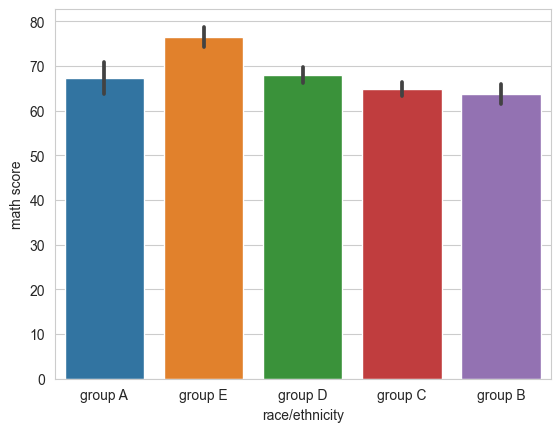

In [9]:
sns.barplot(df_raw, x="race/ethnicity", y="math score")
df_raw[["race/ethnicity", "math score"]].groupby("race/ethnicity").describe()

math score                                                     
            count       mean        std   min   25%   50%   75%    max
gender                                                                
female      495.0  64.880808  14.911885  24.0  56.0  65.0  75.0  100.0
male        505.0  69.786139  15.373840  19.0  60.0  70.0  81.0  100.0

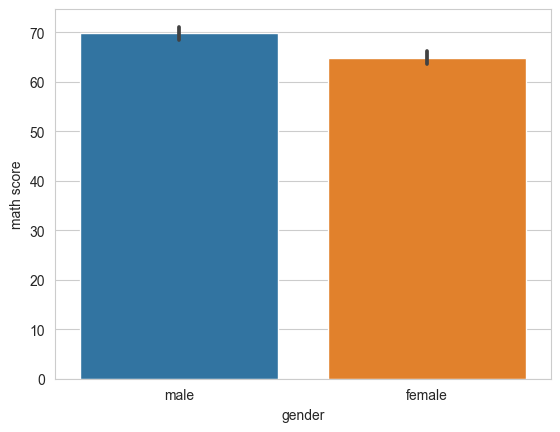

In [10]:
sns.barplot(df_raw, x="gender", y="math score")
df_raw[["gender", "math score"]].groupby("gender").describe()

In [11]:
df = df_raw.dropna()
df = pd.get_dummies(
    df,
    columns=df.drop(["math score", "reading score", "writing score"], axis=1).columns,
)
df = df.drop(
    [
        "gender_female",
        "race/ethnicity_group E",
        "parental level of education_master's degree",
        "lunch_standard",
        "test preparation course_completed",
    ],
    axis=1,
)
df.head()

,math score,reading score,writing score,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,test preparation course_none
0,62,59,53,True,True,False,False,False,False,False,True,False,False,False,True
1,56,62,64,False,False,False,False,False,False,False,False,False,True,True,False
2,91,97,96,False,False,False,False,False,False,False,False,True,False,False,False
3,81,93,99,False,False,False,False,True,False,False,False,True,False,False,False
4,73,62,57,True,False,False,False,False,True,False,False,False,False,True,True


In [12]:
new_cols = []
for col in df.columns:
    col = col.replace("/", "")
    col = col.replace(" ", "_")
    col = col.replace("'", "")
    new_cols.append(col)

df.columns = new_cols

In [13]:
df.columns

Index(['math_score', 'reading_score', 'writing_score', 'gender_male',
       'raceethnicity_group_A', 'raceethnicity_group_B',
       'raceethnicity_group_C', 'raceethnicity_group_D',
       'parental_level_of_education_associates_degree',
       'parental_level_of_education_bachelors_degree',
       'parental_level_of_education_high_school',
       'parental_level_of_education_some_college',
       'parental_level_of_education_some_high_school', 'lunch_freereduced',
       'test_preparation_course_none'],
      dtype='object')

<a id='section_2'></a>

## Train and Assess Python Models

In [14]:
target = "math_score"
features = df.drop(target, axis=1).columns

# train python models #
X_train, X_test, Y_train, Y_test = train_test_split(
    df[features], df[target], train_size=0.7, test_size=0.3, random_state=42
)

In [15]:
lr = LinearRegression()
rfr = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

lr.fit(X_train, Y_train)
rfr.fit(X_train, Y_train)
gbr.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

In [16]:
def sort_feature_importance(model, data):
    features = {}
    for importance, name in sorted(
        zip(model.feature_importances_, data.columns), reverse=True
    ):
        features[name] = str(np.round(importance * 100, 2)) + "%"
    return features

In [17]:
importances = pd.DataFrame.from_dict(
    sort_feature_importance(rfr, X_train), orient="index"
).rename(columns={0: "RandomForest"})
importances["GradientBoosting"] = pd.DataFrame.from_dict(
    sort_feature_importance(gbr, X_train), orient="index"
)
importances

,RandomForest,GradientBoosting
reading_score,63.15%,44.4%
writing_score,19.72%,37.32%
gender_male,9.92%,13.88%
test_preparation_course_none,1.24%,0.75%
lunch_freereduced,1.19%,1.56%
raceethnicity_group_C,0.75%,0.5%
parental_level_of_education_high_school,0.67%,0.11%
parental_level_of_education_associates_degree,0.59%,0.18%
raceethnicity_group_D,0.59%,0.36%
raceethnicity_group_B,0.52%,0.4%


In [18]:
metrics = {
    "LinearRegression": {
        "MSE": mean_squared_error(Y_test, lr.predict(X_test)),
        "MAE": mean_absolute_error(Y_test, lr.predict(X_test)),
        "RSQ": r2_score(Y_test, lr.predict(X_test)),
    },
    "RandomForest": {
        "MSE": mean_squared_error(Y_test, rfr.predict(X_test)),
        "MAE": mean_absolute_error(Y_test, rfr.predict(X_test)),
        "RSQ": r2_score(Y_test, rfr.predict(X_test)),
    },
    "GradientBoost": {
        "MSE": mean_squared_error(Y_test, gbr.predict(X_test)),
        "MAE": mean_absolute_error(Y_test, gbr.predict(X_test)),
        "RSQ": r2_score(Y_test, gbr.predict(X_test)),
    },
}

pd.DataFrame(metrics).transpose()

,MSE,MAE,RSQ
LinearRegression,31.545118,4.548155,0.865483
RandomForest,40.655216,5.211450,0.826635
GradientBoost,32.999321,4.665781,0.859282


<a id='section_3'></a>

## Create Score Tables

In [20]:
# reconstructing race/ethnicity variable
race = pd.from_dummies(
    X_test[
        [
            "raceethnicity_group_A",
            "raceethnicity_group_B",
            "raceethnicity_group_C",
            "raceethnicity_group_D",
        ]
    ],
    sep="_",
    default_category={"raceethnicity": "group_E"},
)
race.head()

,raceethnicity
0,group_D
1,group_D
2,group_A
3,group_C
4,group_C


In [ ]:
# recreating gender variable
gender = X_test["gender_male"].apply(lambda x: "male" if x else "female")
gender.head()

In [ ]:
def build_score_table(model):
    score_data = {
        "Predicted_Math_Score": model.predict(X_test),
        "Math_Score": Y_test.to_numpy(),
        "Race": race.to_numpy()[:, 0],
        "Gender": gender,
    }
    data = pd.DataFrame(score_data)
    return data

In [ ]:
score_tables = {
    "LinearRegression": build_score_table(lr),
    "RandomForest": build_score_table(rfr),
    "GradientBoost": build_score_table(gbr),
}

In [ ]:
for k, v in score_tables.items():
    print(f"{k} \n {v.head()}")

<a id='section_4'></a>

## Using `assess_model_bias()`

In [ ]:
# setting up environment
hostname = ""
username = input("Username: ")
password = getpass.getpass("Password: ")  # changes required by user

sess = Session(hostname, username, password, protocol="http")

In [ ]:
# Model names within SAS Model Manager
model_prefix = ["LinearRegression", "RandomForest", "GradientBoost"]
# Directory location for the model files
zip_folder = [
    Path.cwd() / "data/BiasMetrics/examModels/LinearRegression/",
    Path.cwd() / "data/BiasMetrics/examModels/RandomForest/",
    Path.cwd() / "data/BiasMetrics/examModels/GradientBoost",
]  # Changes required by user
model = [lr, rfr, gbr]

In [ ]:
# creating assess bias json files and getting dataframes
assess_bias_dfs = {}

for model, path in zip(model_prefix, zip_folder):
    dfs = pzmm.JSONFiles.assess_model_bias(
        score_table=score_tables[model],
        actual_values="Math_Score",  # variable for actual value in score table
        sensitive_values=[
            "Race",
            "Gender",
        ],  # variables for sensitive values in score table
        pred_values="Predicted_Math_Score",  # variable for predicted values in score table (regression)
        json_path=path,  # directory for json files, optional
        return_dataframes=True,  # returns group metrics, bias metrics, and max differences data frames, default is False
    )

    assess_bias_dfs[model] = dfs

<a id = 'section_5' > </a >

## Assess Model Bias Output

### Examples of the Data Frames

In [117]:
assess_bias_dfs["LinearRegression"]["groupMetricsData"].head(7)

,LEVEL,Predicted_Math_Score,VLABEL,_DATAROLE_,_VARIABLE_,_ase_,_avgyhat_,_mae_,_msle_,_nobs_,_rase_,_rmae_,_rmsle_
0,group_A,65.939598,,TEST,Race,43.580554,65.939598,5.440171,0.009283,23.0,6.601557,2.332417,0.096346
1,group_B,65.635744,,TEST,Race,38.598601,65.635744,5.097320,0.010109,55.0,6.212777,2.257725,0.100543
2,group_C,63.858842,,TEST,Race,27.848870,63.858842,4.270016,0.008939,111.0,5.277203,2.066402,0.094544
3,group_D,68.684169,,TEST,Race,28.578134,68.684169,4.249801,0.007391,77.0,5.345852,2.061505,0.085971
4,group_E,75.143961,,TEST,Race,30.779962,75.143961,4.640106,0.005884,34.0,5.547969,2.154090,0.076708
0,female,65.049752,,TEST,Gender,29.756506,65.049752,4.464487,0.007656,155.0,5.454952,2.112933,0.087499
1,male,68.798429,,TEST,Gender,33.457083,68.798429,4.637594,0.009270,145.0,5.784210,2.153507,0.096281


In [118]:
# race/ethnicity
assess_bias_dfs["LinearRegression"]["maxDifferencesData"].head(3)

,BASE,COMPARE,Metric,MetricLabel,VLABEL,_DATAROLE_,_VARIABLE_,maxdiff
0,group_E,group_C,Predicted_Math_Score,Average Predicted_Math_Score,,TEST,Race,11.285119
1,group_A,group_C,ASE,Average Square Error,,TEST,Race,15.731684
2,group_A,group_C,RASE,Root Average Square Error,,TEST,Race,1.324354


In [119]:
# gender
assess_bias_dfs["LinearRegression"]["maxDifferencesData"].tail(3)

,BASE,COMPARE,Metric,MetricLabel,VLABEL,_DATAROLE_,_VARIABLE_,maxdiff
5,male,female,MSLE,Mean Square Logarithmic Error,,TEST,Gender,0.001614
6,male,female,RMSLE,Root Mean Square Logarithmic Error,,TEST,Gender,0.008782
7,male,female,PREDICTED,Average Prediction,,TEST,Gender,3.748677


In [120]:
assess_bias_dfs["LinearRegression"]["biasMetricsData"].head()

,Metric,MetricLabel,Value,Base,Compare,Note,_VARIABLE_
0,PredictiveParity,Predictive Parity,11.285119,group_E,group_C,,Race
0,PredictiveParity,Predictive Parity,3.748677,male,female,,Gender


In [121]:
gm_lr = assess_bias_dfs["LinearRegression"]["groupMetricsData"]
gm_rfr = assess_bias_dfs["RandomForest"]["groupMetricsData"]
gm_gbr = assess_bias_dfs["GradientBoost"]["groupMetricsData"]

In [122]:
md_lr = assess_bias_dfs["LinearRegression"]["maxDifferencesData"]
md_rfr = assess_bias_dfs["RandomForest"]["maxDifferencesData"]
md_gbr = assess_bias_dfs["GradientBoost"]["maxDifferencesData"]

### Performance Bias

In [123]:
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.autolayout"] = True

Average Squared Error: $$ASE = \frac{1}{n-p} \sum_{i=1}^{n} (y_i - \hat{y_i})^2$$

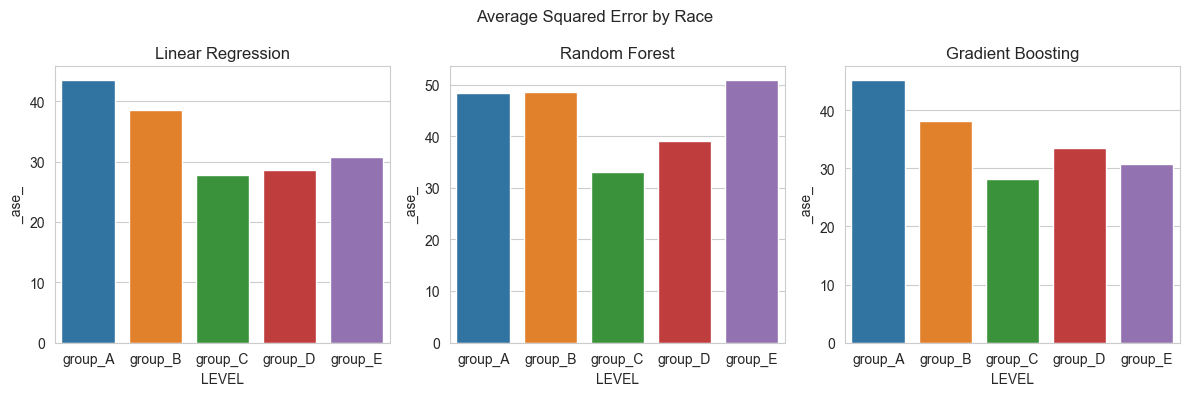

In [124]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Average Squared Error by Race")

sns.barplot(
    data=gm_lr[gm_lr["_VARIABLE_"] == "Race"], x="LEVEL", y="_ase_", ax=axes[0]
).set(title="Linear Regression")
sns.barplot(
    data=gm_rfr[gm_rfr["_VARIABLE_"] == "Race"], x="LEVEL", y="_ase_", ax=axes[1]
).set(title="Random Forest")
sns.barplot(
    data=gm_gbr[gm_gbr["_VARIABLE_"] == "Race"], x="LEVEL", y="_ase_", ax=axes[2]
).set(title="Gradient Boosting")

plt.show()

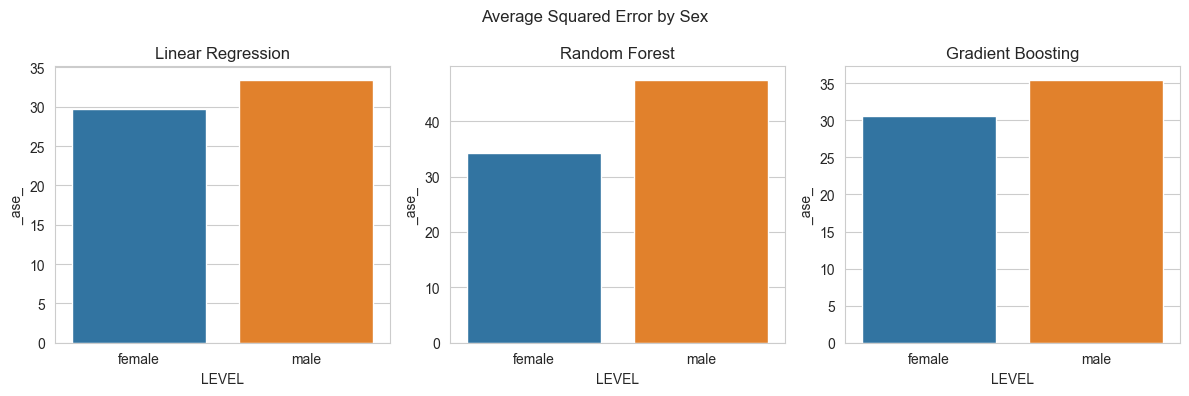

In [125]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Average Squared Error by Sex")

sns.barplot(
    data=gm_lr[gm_lr["_VARIABLE_"] == "Gender"], x="LEVEL", y="_ase_", ax=axes[0]
).set(title="Linear Regression")
sns.barplot(
    data=gm_rfr[gm_rfr["_VARIABLE_"] == "Gender"], x="LEVEL", y="_ase_", ax=axes[1]
).set(title="Random Forest")
sns.barplot(
    data=gm_gbr[gm_gbr["_VARIABLE_"] == "Gender"], x="LEVEL", y="_ase_", ax=axes[2]
).set(title="Gradient Boosting")

plt.show()

In [126]:
md_ase_lr_race = md_lr[(md_lr["Metric"] == "ASE") & (md_lr["_VARIABLE_"] == "Race")][
    "maxdiff"
]
md_ase_lr_sex = md_lr[(md_lr["Metric"] == "ASE") & (md_lr["_VARIABLE_"] == "Gender")][
    "maxdiff"
]
md_ase_lr = [x.values[0] for x in [md_ase_lr_race, md_ase_lr_sex]]

md_ase_rfr_race = md_rfr[
    (md_rfr["Metric"] == "ASE") & (md_rfr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_ase_rfr_sex = md_rfr[
    (md_rfr["Metric"] == "ASE") & (md_rfr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_ase_rfr = [x.values[0] for x in [md_ase_rfr_race, md_ase_rfr_sex]]

md_ase_gbr_race = md_gbr[
    (md_gbr["Metric"] == "ASE") & (md_gbr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_ase_gbr_sex = md_gbr[
    (md_gbr["Metric"] == "ASE") & (md_gbr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_ase_gbr = [x.values[0] for x in [md_ase_gbr_race, md_ase_gbr_sex]]

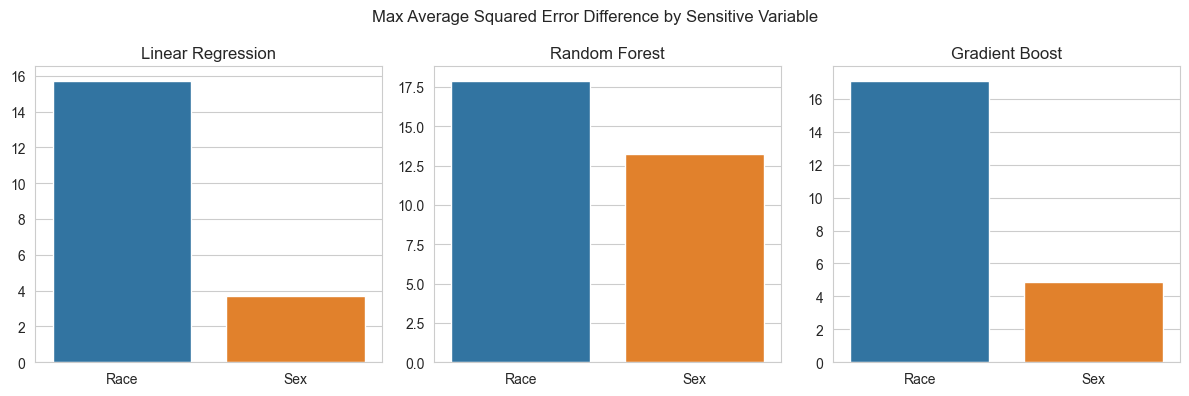

In [127]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Max Average Squared Error Difference by Sensitive Variable")

sns.barplot(y=md_ase_lr, x=["Race", "Sex"], ax=axes[0]).set(title="Linear Regression")
sns.barplot(y=md_ase_rfr, x=["Race", "Sex"], ax=axes[1]).set(title="Random Forest")
sns.barplot(y=md_ase_gbr, x=["Race", "Sex"], ax=axes[2]).set(title="Gradient Boost")

plt.show()

Root Average Squared Error: $$RASE = \sqrt{\frac{1}{n-p} \sum_{i=1}^{n} (y_i - \hat{y_i})^2}$$

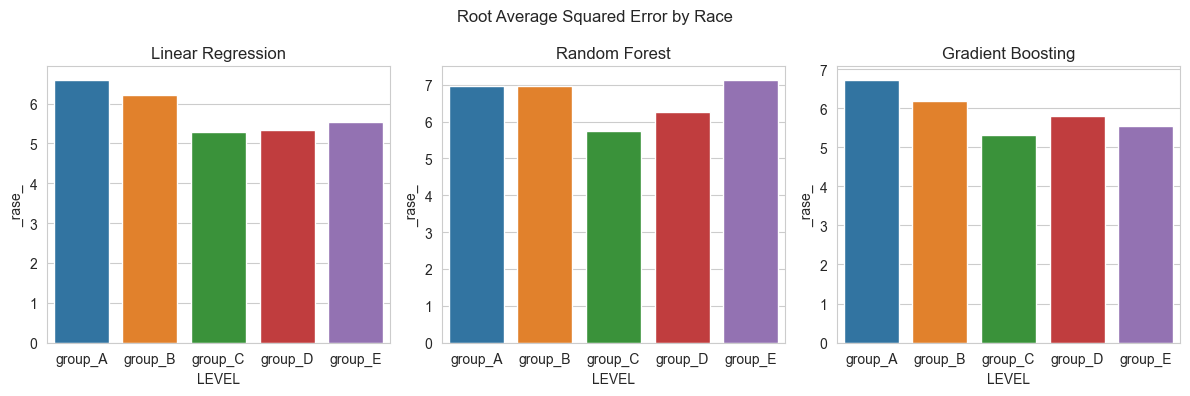

In [128]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Root Average Squared Error by Race")

sns.barplot(
    data=gm_lr[gm_lr["_VARIABLE_"] == "Race"], x="LEVEL", y="_rase_", ax=axes[0]
).set(title="Linear Regression")
sns.barplot(
    data=gm_rfr[gm_rfr["_VARIABLE_"] == "Race"], x="LEVEL", y="_rase_", ax=axes[1]
).set(title="Random Forest")
sns.barplot(
    data=gm_gbr[gm_gbr["_VARIABLE_"] == "Race"], x="LEVEL", y="_rase_", ax=axes[2]
).set(title="Gradient Boosting")

plt.show()

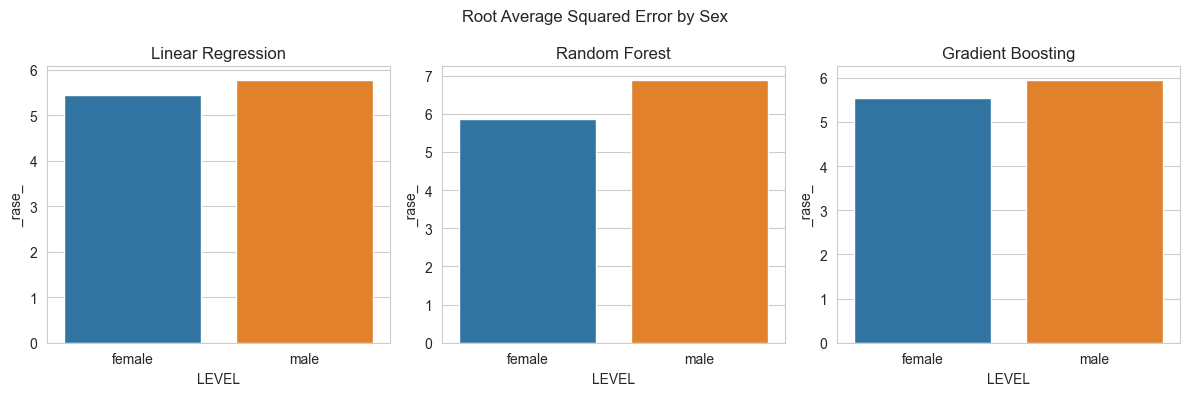

In [129]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Root Average Squared Error by Sex")

sns.barplot(
    data=gm_lr[gm_lr["_VARIABLE_"] == "Gender"], x="LEVEL", y="_rase_", ax=axes[0]
).set(title="Linear Regression")
sns.barplot(
    data=gm_rfr[gm_rfr["_VARIABLE_"] == "Gender"], x="LEVEL", y="_rase_", ax=axes[1]
).set(title="Random Forest")
sns.barplot(
    data=gm_gbr[gm_gbr["_VARIABLE_"] == "Gender"], x="LEVEL", y="_rase_", ax=axes[2]
).set(title="Gradient Boosting")

plt.show()

In [130]:
md_rase_lr_race = md_lr[(md_lr["Metric"] == "RASE") & (md_lr["_VARIABLE_"] == "Race")][
    "maxdiff"
]
md_rase_lr_sex = md_lr[(md_lr["Metric"] == "RASE") & (md_lr["_VARIABLE_"] == "Gender")][
    "maxdiff"
]
md_rase_lr = [x.values[0] for x in [md_rase_lr_race, md_rase_lr_sex]]

md_rase_rfr_race = md_rfr[
    (md_rfr["Metric"] == "RASE") & (md_rfr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_rase_rfr_sex = md_rfr[
    (md_rfr["Metric"] == "RASE") & (md_rfr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_rase_rfr = [x.values[0] for x in [md_rase_rfr_race, md_rase_rfr_sex]]

md_rase_gbr_race = md_gbr[
    (md_gbr["Metric"] == "RASE") & (md_gbr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_rase_gbr_sex = md_gbr[
    (md_gbr["Metric"] == "RASE") & (md_gbr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_rase_gbr = [x.values[0] for x in [md_rase_gbr_race, md_rase_gbr_sex]]

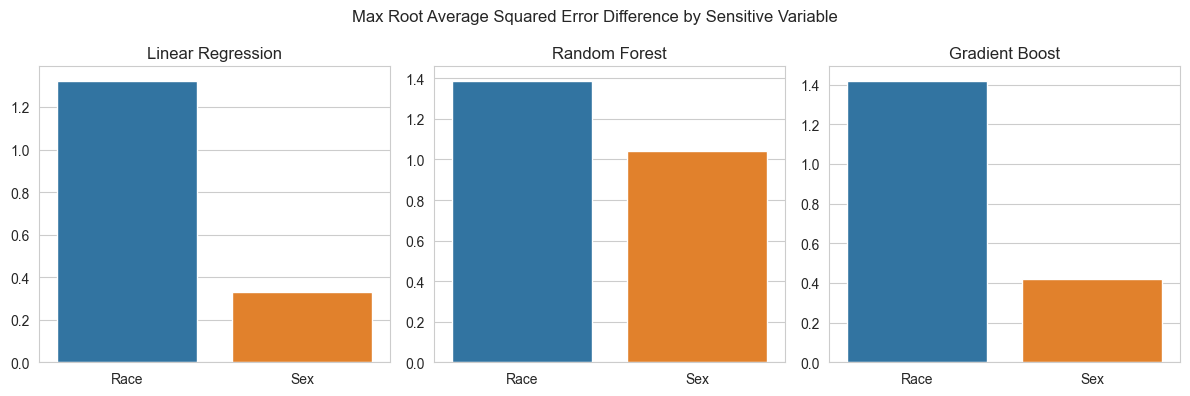

In [131]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Max Root Average Squared Error Difference by Sensitive Variable")

sns.barplot(y=md_rase_lr, x=["Race", "Sex"], ax=axes[0]).set(title="Linear Regression")
sns.barplot(y=md_rase_rfr, x=["Race", "Sex"], ax=axes[1]).set(title="Random Forest")
sns.barplot(y=md_rase_gbr, x=["Race", "Sex"], ax=axes[2]).set(title="Gradient Boost")

plt.show()

### Prediction Bias

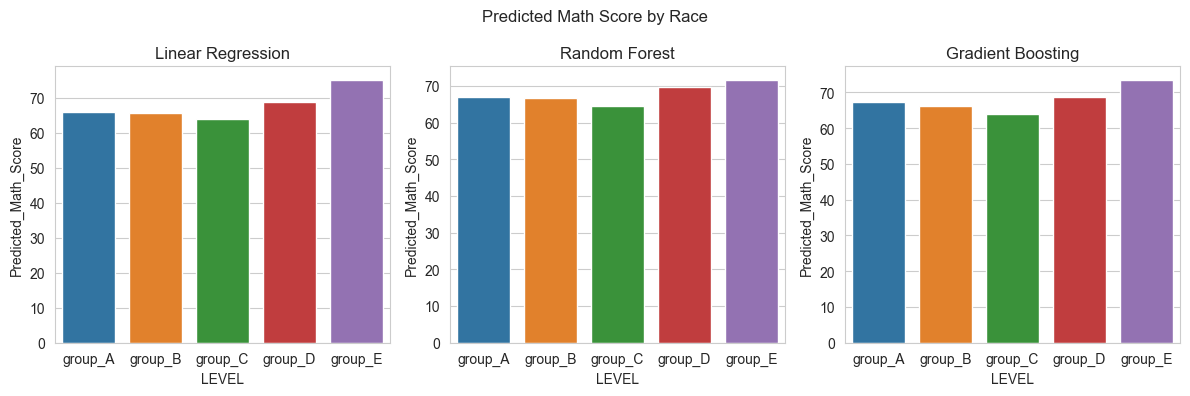

In [132]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Predicted Math Score by Race")

sns.barplot(
    data=gm_lr[gm_lr["_VARIABLE_"] == "Race"],
    x="LEVEL",
    y="Predicted_Math_Score",
    ax=axes[0],
).set(title="Linear Regression")
sns.barplot(
    data=gm_rfr[gm_rfr["_VARIABLE_"] == "Race"],
    x="LEVEL",
    y="Predicted_Math_Score",
    ax=axes[1],
).set(title="Random Forest")
sns.barplot(
    data=gm_gbr[gm_gbr["_VARIABLE_"] == "Race"],
    x="LEVEL",
    y="Predicted_Math_Score",
    ax=axes[2],
).set(title="Gradient Boosting")

plt.show()

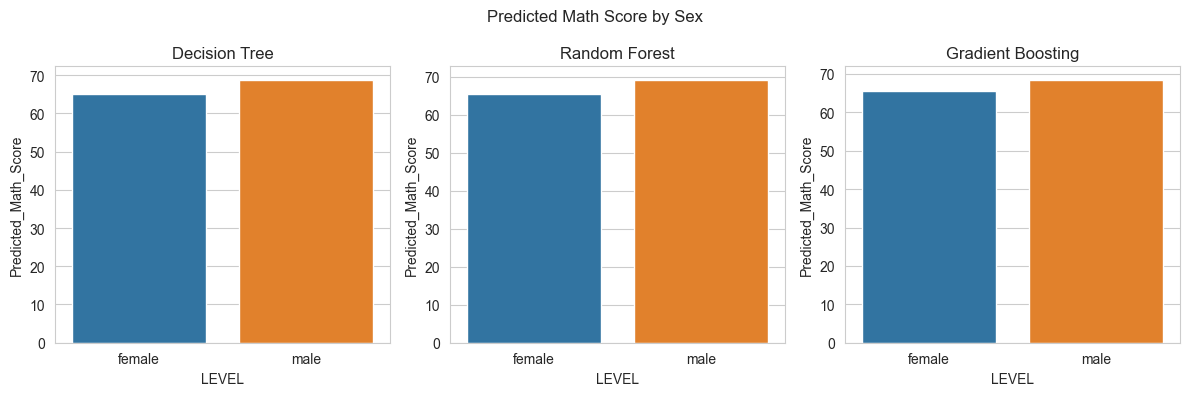

In [133]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Predicted Math Score by Sex")

sns.barplot(
    data=gm_lr[gm_lr["_VARIABLE_"] == "Gender"],
    x="LEVEL",
    y="Predicted_Math_Score",
    ax=axes[0],
).set(title="Decision Tree")
sns.barplot(
    data=gm_rfr[gm_rfr["_VARIABLE_"] == "Gender"],
    x="LEVEL",
    y="Predicted_Math_Score",
    ax=axes[1],
).set(title="Random Forest")
sns.barplot(
    data=gm_gbr[gm_gbr["_VARIABLE_"] == "Gender"],
    x="LEVEL",
    y="Predicted_Math_Score",
    ax=axes[2],
).set(title="Gradient Boosting")

plt.show()

In [134]:
md_pe_lr_race = md_lr[
    (md_lr["Metric"] == "Predicted_Math_Score") & (md_lr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_pe_lr_sex = md_lr[
    (md_lr["Metric"] == "Predicted_Math_Score") & (md_lr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_pe_lr = [x.values[0] for x in [md_pe_lr_race, md_pe_lr_sex]]

md_pe_rfr_race = md_rfr[
    (md_rfr["Metric"] == "Predicted_Math_Score") & (md_rfr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_pe_rfr_sex = md_rfr[
    (md_rfr["Metric"] == "Predicted_Math_Score") & (md_rfr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_pe_rfr = [x.values[0] for x in [md_pe_rfr_race, md_pe_rfr_sex]]

md_pe_gbr_race = md_gbr[
    (md_gbr["Metric"] == "Predicted_Math_Score") & (md_gbr["_VARIABLE_"] == "Race")
]["maxdiff"]
md_pe_gbr_sex = md_gbr[
    (md_gbr["Metric"] == "Predicted_Math_Score") & (md_gbr["_VARIABLE_"] == "Gender")
]["maxdiff"]
md_pe_gbr = [x.values[0] for x in [md_pe_gbr_race, md_pe_gbr_sex]]

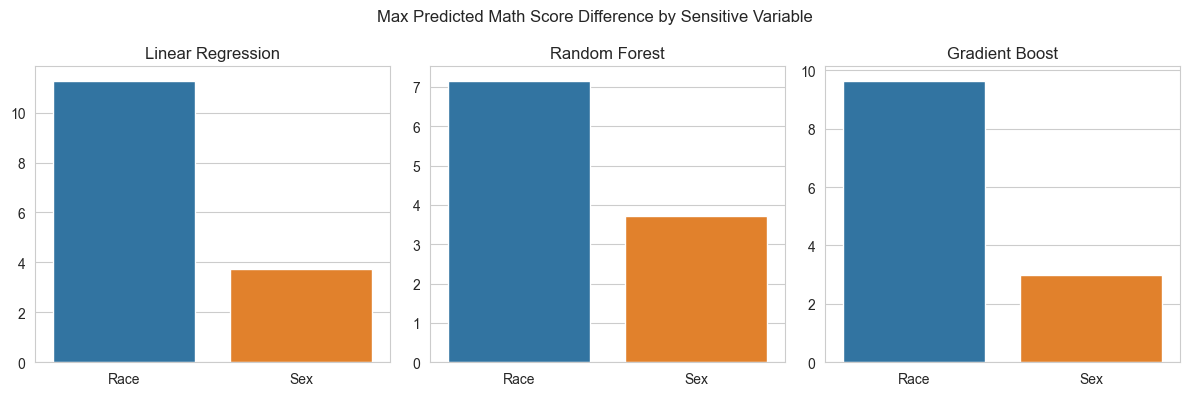

In [135]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Max Predicted Math Score Difference by Sensitive Variable")

sns.barplot(y=md_pe_lr, x=["Race", "Sex"], ax=axes[0]).set(title="Linear Regression")
sns.barplot(y=md_pe_rfr, x=["Race", "Sex"], ax=axes[1]).set(title="Random Forest")
sns.barplot(y=md_pe_gbr, x=["Race", "Sex"], ax=axes[2]).set(title="Gradient Boost")

plt.show()

***